# New Run
A_01: Copy from SL_D_E_4.ipynb. Fixed the problem as we have found in normalization. This time we normalize over the whole course. 


A_05: This time we resume using two linear layers, one before RNN and one after. IN this way we make the last linear layer of both encoder and decoder
a pure linear layer without other components. 

A_07: This time we delete the attention part of the decoder and make it completely autoregressive. See how it performs. 

A_08: Restore the inclusion of attention mechanism, and set the first input to decoder to all zero. 

A_10: This time we want to really try the autoregressive model and see how well it performs. 

A_12: This time resume to SimplePhxLearner structure, LinearPack -LayerNorm and +Tanh. In addition added LastElementExtractor. 

A_15: slightly play a bit with the model, see whether it can improve. LastElementExtractor should not be wrong. In addition, may play a bit with the model layering, as well as some components in LinearPack. We disable dropout first to see what can happen. [New: LastElementExtractor may be a wrong facility]

A_16: Just change the activation function in linpack from tanh to relu, which may not be correct, but just try. 

A_17: This time keep the activation function as ReLU and add layernorm. 

# Sequence Learning - Direct - English
Version 1: In this version we make the model "simple": make the encoder RNN into normal RNN first and try to see the result.  
Version 2: Learning is not very much. Following Dr Coupe's advice we try simpler model structure.   
Version 3: A simple trial training with Mel spectrogram instead of MFCC.   
Version 4: try to enlarge the hidden dimensions so that we might still make sense of the hidden representation. 

In [1]:
import torch
import torchaudio
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence, pack_sequence
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from datetime import datetime
import random
from torchinfo import summary

In [2]:
from model import SimplerPhxLearnerInit as TheLearner
from my_dataset import DS_Tools
from dataset import SeqDataset, MelTransform, Normalizer, DeNormalizer
from dataset import MelSpecTransformNoDB as TheTransform
from paths import *
from my_utils import *
from recorder import *
from loss import *
from padding import generate_mask_from_lengths_mat, mask_it

### Dirs

In [3]:
model_save_dir = model_eng_save_dir
# random_data:phone_seg_random_path
# anno_data: phone_seg_anno_path

# random_log_path = phone_seg_random_log_path + "log.csv"
random_log_path = word_seg_anno_log_path
random_path = word_seg_anno_path
anno_log_path = phone_seg_anno_path

### Constants

In [4]:
BATCH_SIZE = 128

INPUT_DIM = 64
OUTPUT_DIM = 64 

INTER_DIM_0 = 32
INTER_DIM_1 = 16
INTER_DIM_2 = 8

ENC_SIZE_LIST = [INPUT_DIM, INTER_DIM_0, INTER_DIM_1, INTER_DIM_2]
DEC_SIZE_LIST = [OUTPUT_DIM, INTER_DIM_0, INTER_DIM_1, INTER_DIM_2]

DROPOUT = 0.5

REC_SAMPLE_RATE = 16000
N_FFT = 400
N_MELS = 64

LOADER_WORKER = 16
# LOADER_WORKER = 0

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
recon_loss = nn.MSELoss(reduction='none')
masked_recon_loss = MaskedLoss(recon_loss)
model_loss = masked_recon_loss

model = TheLearner(enc_size_list=ENC_SIZE_LIST, dec_size_list=DEC_SIZE_LIST, num_layers=2)
# model = TheLearner(enc_size_list=ENC_SIZE_LIST, dec_size_list=DEC_SIZE_LIST, num_layers=1)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [6]:
# # initialize model weights
# def init_weights(m):
#     if isinstance(m, nn.Linear):
#         torch.nn.init.orthogonal_(m.weight)
#         m.bias.data.fill_(0.01)
#     if isinstance(m, nn.LSTM): 
#         for name, p in m.named_parameters():
#             if "weight" in name: 
#                 nn.init.orthogonal_(p)
#             elif "bias" in name: 
#                 nn.init.constant_(p, 0)

# model.apply(init_weights)

In [7]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

In [8]:
params

11440

In [9]:
# Just for keeping records of training hists. 
# ts = "0918192113"
stop_epoch = "149"
ts = str(get_timestamp())
save_txt_name = "train_txt_{}.hst".format(ts)
save_trainhist_name = "train_hist_{}.hst".format(ts)

save_valhist_name = "val_hist_{}.hst".format(ts)

In [10]:
train_losses = LossRecorder(model_save_dir + save_trainhist_name)

valid_losses = LossRecorder(model_save_dir + save_valhist_name)

text_hist = HistRecorder(model_save_dir + save_txt_name)

In [11]:
READ = False
# READ = True

In [12]:
if READ: 
    valid_losses.read()
    train_losses.read()

    model_raw_name = "PT_{}_{}_full".format(ts, stop_epoch)
    model_name = model_raw_name + ".pt"
    model_path = os.path.join(model_save_dir, model_name)
    state = torch.load(model_path)

    model.load_state_dict(state)
    model.to(device)

In [13]:
model

SimplerPhxLearnerInit(
  (encoder): RLEncoder(
    (rnn): LSTM(64, 16, num_layers=2, batch_first=True)
    (lin_2): LinearPack(
      (linear): Linear(in_features=16, out_features=8, bias=True)
      (layernorm): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
      (relu): ReLU()
    )
  )
  (decoder): InitRALDecoder(
    (rnn): LSTM(64, 8, num_layers=2, batch_first=True)
    (attention): ScaledDotProductAttention(
      (w_q): Linear(in_features=8, out_features=8, bias=True)
      (w_k): Linear(in_features=8, out_features=8, bias=True)
      (w_v): Linear(in_features=8, out_features=8, bias=True)
    )
    (lin_3): LinearPack(
      (linear): Linear(in_features=8, out_features=64, bias=True)
      (layernorm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (relu): ReLU()
    )
  )
)

In [14]:
DATAREAD = False

In [15]:
# mytrans = MelSpecTransform(sample_rate=REC_SAMPLE_RATE, n_fft=N_FFT, n_mels=N_MELS)
# mytrans = nn.Sequential(
#     MelTransform(sample_rate=REC_SAMPLE_RATE, n_fft=N_FFT, n_mels=N_MELS),
#     # torchaudio.transforms.AmplitudeToDB(stype="power", top_db=80), 
#     Normalizer(Normalizer.norm_strip_minmax)
# )
# mytrans = TheTransform(sample_rate=REC_SAMPLE_RATE, n_fft=N_FFT, n_mels=N_MELS, normalizer=Normalizer.norm_strip_mvn, denormalizer=DeNormalizer.norm_strip_mvn)
mytrans = TheTransform(sample_rate=REC_SAMPLE_RATE, n_fft=N_FFT, n_mels=N_MELS, normalizer=Normalizer.norm_mvn, denormalizer=DeNormalizer.norm_mvn)
ds = SeqDataset(random_path, os.path.join(random_log_path, "log.csv"), transform=mytrans)

test = False
if test: 
    use_len = int(0.1 * len(ds))
    remain_len = len(ds) - use_len

    # Randomly split the dataset into train and validation sets
    ds, remain_ds = random_split(ds, [use_len, remain_len])


if READ or DATAREAD: 
    valid_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, "valid_ds_{}.pkl".format(ts)))
    all_indices = list(range(len(ds)))
    train_ds_indices = list(set(all_indices).difference(set(valid_ds_indices)))

    train_ds = torch.utils.data.Subset(ds, train_ds_indices)
    valid_ds = torch.utils.data.Subset(ds, valid_ds_indices)
else: 
    train_len = int(0.8 * len(ds))
    valid_len = len(ds) - train_len

    # Randomly split the dataset into train and validation sets
    train_ds, valid_ds = random_split(ds, [train_len, valid_len])
    DS_Tools.save_indices(os.path.join(model_save_dir, "valid_ds_{}.pkl".format(ts)), valid_ds.indices)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=LOADER_WORKER, collate_fn=SeqDataset.collate_fn)
train_num = len(train_loader.dataset)

valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKER, collate_fn=SeqDataset.collate_fn)
valid_num = len(valid_loader.dataset)


In [16]:
len(train_loader)

1776

In [17]:
# Load sample data from train_loader
sample_data = next(iter(valid_loader))
xx_pad, seg = sample_data
print(xx_pad.shape)

torch.Size([128, 67, 64])


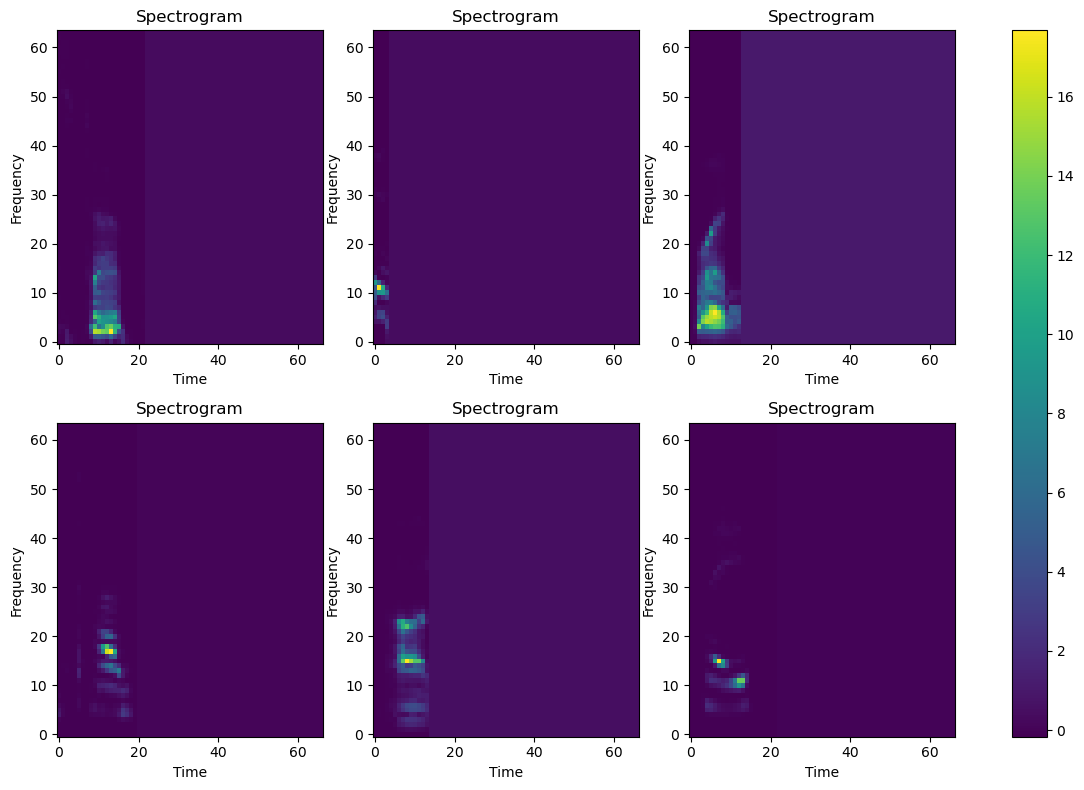

In [18]:
# Set the random seed for reproducibility
# random.seed(101)
# Generate six random indices
# random_indices = random.sample(range(len(xx_pad)), 6)
random_indices = list(range(6, 12))

# Plot the spectrograms and mark the corresponding seg
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, idx in enumerate(random_indices):
    spectrogram = xx_pad[idx]
    
    ax = axes[i]
    img = ax.imshow(spectrogram.T, aspect='auto', origin="lower")
    # ax.axvline(x=segment, color='red', linestyle='--')
    # ax.axvline(x=segment[1], color='red', linestyle='--')
    ax.set_title(f'Spectrogram')
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')
plt.tight_layout()
plt.colorbar(img,ax=axes)
plt.show()

In [19]:
ts

'0126182637'

In [23]:
EPOCHS = 30
BASE = 0

In [24]:
def train(): 
    for epoch in range(BASE, BASE + EPOCHS):
        text_hist.print("Epoch {}".format(epoch))

        model.train()
        train_loss = 0.
        train_num = len(train_loader)    # train_loader
        for idx, (x, x_lens) in enumerate(train_loader):
            optimizer.zero_grad()
            y = x 
            
            x_mask = generate_mask_from_lengths_mat(x_lens, device=device)
            
            x = x.to(device)
            y = y.to(device)

            recon_x, attn_weight = model(x, x_lens, x_mask)

            loss = model_loss.get_loss(recon_x, y, x_mask)

            train_loss += loss.item()

            loss.backward()
            
            # torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            # 这个函数计算的是全局梯度范数
            # torch.nn.utils.clip_grad_norm(parameters=model.parameters(), max_norm=5, norm_type=2)
            torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=5, norm_type=2)
            # parameters: an iterable of Variables that will have gradients normalized
            # max_norm: max norm of the gradients(阈值设定)
            # norm_type: type of the used p-norm. Can be'inf'for infinity norm(定义范数类型)

            optimizer.step()

            if idx % 100 == 0:
                text_hist.print(f"Training loss {loss: .3f} in Step {idx}")

        train_losses.append(train_loss / train_num)
        text_hist.print(f"※※※Training loss {train_loss / train_num: .3f}※※※")

        last_model_name = "PT_{}_{}_full.pt".format(ts, epoch)
        torch.save(model.state_dict(), os.path.join(model_save_dir, last_model_name))
        text_hist.print("Training timepoint saved")

        model.eval()
        valid_loss = 0.
        valid_num = len(valid_loader)
        for idx, (x, x_lens) in enumerate(valid_loader):
            y = x    # extract MFCC-only data
            x_mask = generate_mask_from_lengths_mat(x_lens, device=device)
            
            x = x.to(device)
            y = y.to(device)

            recon_x, attn_weight = model(x, x_lens, x_mask)

            loss = model_loss.get_loss(recon_x, y, x_mask)

            valid_loss += loss.item()

            if idx % 50 == 0:
                text_hist.print(f"Valid loss {loss: .3f} in Step {idx}")

        valid_losses.append(valid_loss / valid_num)

        text_hist.print(f"※※※Valid loss {valid_loss / valid_num: .3f}※※※")

In [25]:
if __name__ == "__main__": 
    train()

Epoch 0
Training loss  1.110 in Step 0
Training loss  0.900 in Step 100
Training loss  0.888 in Step 200
Training loss  0.865 in Step 300
Training loss  0.825 in Step 400
Training loss  0.772 in Step 500
Training loss  0.697 in Step 600
Training loss  0.683 in Step 700
Training loss  0.610 in Step 800
Training loss  0.583 in Step 900
Training loss  0.638 in Step 1000
Training loss  0.580 in Step 1100
Training loss  0.556 in Step 1200
Training loss  0.549 in Step 1300
Training loss  0.564 in Step 1400
Training loss  0.580 in Step 1500
Training loss  0.570 in Step 1600
Training loss  0.541 in Step 1700
※※※Training loss  0.681※※※
Training timepoint saved
Valid loss  0.519 in Step 0
Valid loss  0.573 in Step 50
Valid loss  0.544 in Step 100
Valid loss  0.546 in Step 150
Valid loss  0.510 in Step 200
Valid loss  0.536 in Step 250
Valid loss  0.526 in Step 300
Valid loss  0.576 in Step 350
Valid loss  0.555 in Step 400
※※※Valid loss  0.552※※※
Epoch 1
Training loss  0.557 in Step 0
Training l

In [26]:
### Save
train_losses.save()

valid_losses.save()

text_hist.save()

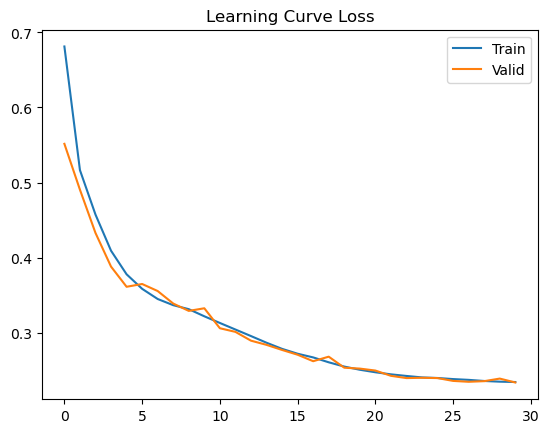

In [27]:
plt.plot(train_losses.get(), label='Train')
plt.plot(valid_losses.get(), label='Valid')
plt.title("Learning Curve Loss")
plt.legend()

## Conclusion
This model should converge to loss around 0.49x. 